<a href="https://colab.research.google.com/github/tornikeo/lut-gpgpu-course/blob/main/gpgpu_e3_tornikeo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Student: Tornike Onoprishvili   
Exercise 3. "CuPy is a nice library"

In [1]:
from math import ceil as roof

import numpy as np
import cupy as cp
from cupy import cuda

assert cuda.is_available()


In all tasks execution times can vary between executions, so run them for example 100 times and take the average time.

Use for suitably different vector and matrix sizes to show the performance difference  and plot them into same graph. 


## Task 1: 

 Both NumPy and CuPy offer the linear algebra functions  linalg.norm() to get the norm and linalg.qr() to get the QR decomposition of matrices.

Time their performance against different sizes of square matrices.

In [2]:
# First we do the lazy kernel design
cp.random.seed(42)

matrices = [
    np.random.uniform(size=(size,size)).astype('float32')
    for size in np.logspace(base=2, start=6, stop=14, num=7, endpoint=True, dtype='int32')
]
matrices[-1].shape

(16384, 16384)

In [3]:
matrices[4].shape

(2580, 2580)

In [4]:
from contextlib import contextmanager
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class FanciestTimerEver:
    """This is like the Rolex of python timers."""
    def __enter__(self):
        self.duration =- time.perf_counter()
        return self
    def __exit__(self, *args):
        self.duration += time.perf_counter()

/tmp/ipykernel_38485/292589195.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
# It felt pretty clever to compress it like this :)

data = []
for lib in [np, cp]:
    for op in [lib.linalg.norm, lib.linalg.qr]:
        mean_times = []
        for matrix in matrices:
            if op is lib.linalg.qr and matrix.shape[0] > 2048: 
                # Skip annoyingly slow ones
                continue
            matrix = lib.array(matrix)
            times = []
            # Run once for warm-up
            op(matrix)
            for _ in range(100):
                with FanciestTimerEver() as timer:
                    op(matrix)
                times.append(timer.duration)    
            data.append([lib.__name__, op.__name__, matrix.shape[0], sum(times)/len(times)])
            
df = pd.DataFrame(data, columns='Lib Op Size Time'.split())

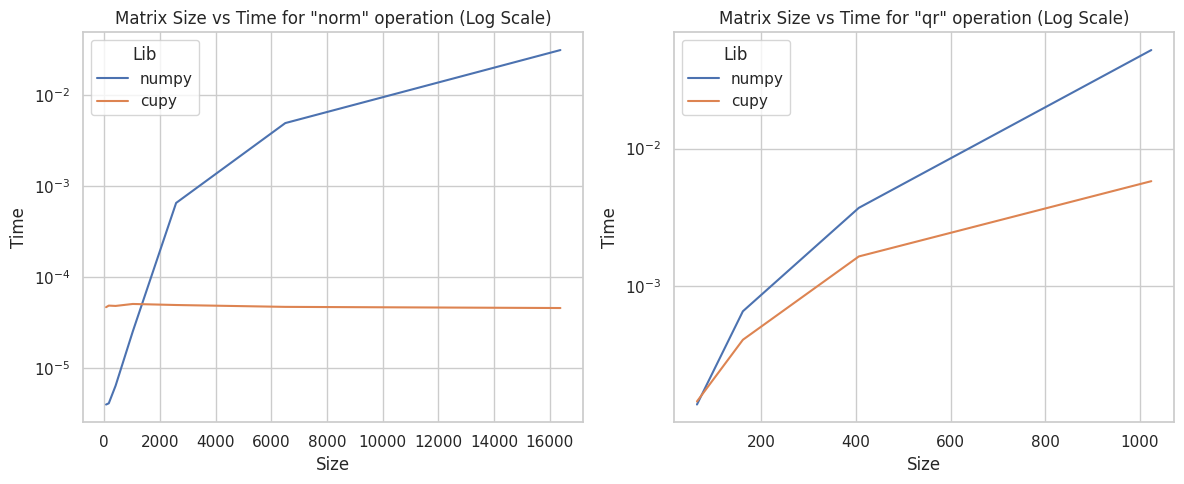

In [6]:
# ... and this bit is totally not written by AI, I swear...

sns.set(style="whitegrid")
plt.figure(figsize=(12, 5))

# Plot 1: Matrix size vs Time for 'norm' operation (log scale)
plt.subplot(1, 2, 1)
sns.lineplot(x='Size', y='Time', hue='Lib', data=df[df['Op'] == 'norm'])
plt.title('Matrix Size vs Time for "norm" operation (Log Scale)')
plt.yscale('log')

# Plot 2: Matrix size vs Time for 'qr' operation (log scale)
plt.subplot(1, 2, 2)
sns.lineplot(x='Size', y='Time', hue='Lib', data=df[df['Op'] == 'qr'])
plt.title('Matrix Size vs Time for "qr" operation (Log Scale)')
plt.yscale('log')

plt.tight_layout()
plt.show()

## Task 2:

Implement vector addition using NumPy, CuPy and an example kernel used in previous exercises. Time their performance against different vector sizes.

In [7]:
data = []
for size in [2**i for i in range(5, 15)]:
    # Generate random vectors
    numpy_vector = np.random.rand(size).astype(np.float32)
    cupy_vector = cp.asarray(numpy_vector)

    # NumPy timing
    with FanciestTimerEver() as timer:
        for _ in range(100):
            np_result = np.add(numpy_vector, numpy_vector)

    data.append(['numpy', size, timer.duration / 100])

    # CuPy timing
    with FanciestTimerEver() as timer:
        for _ in range(100):
            cp_result = cp.add(cupy_vector, cupy_vector)

    data.append(['cupy', size, timer.duration / 100])

    # Custom RawKernel timing
    kernel = cp.RawKernel(r'''
        extern "C" __global__
        void custom_add(const float* a, const float* b, float* result, int size) {
            int idx = blockIdx.x * blockDim.x + threadIdx.x;
            if (idx < size) {
                result[idx] = a[idx] + b[idx];
            }
        }
    ''', 'custom_add')

    with FanciestTimerEver() as timer:
        for _ in range(100):
            custom_result = cp.empty_like(cupy_vector)
            kernel((size,1,1), 
                   (1,1,1),
                   (cupy_vector, cupy_vector, 
                                   custom_result, 
                                   cp.int32(size)))

    data.append(['custom', size, timer.duration / 100])

# Create a DataFrame
df = pd.DataFrame(data, columns=['Method', 'Size', 'Time'])

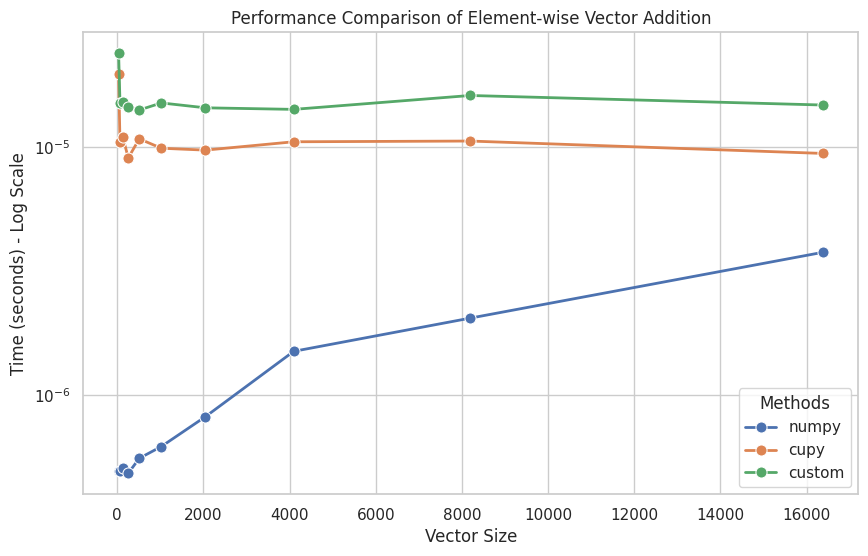

In [8]:
# Plotting the performance comparison
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot: Method vs Time for different vector sizes (log scale)
sns.lineplot(x='Size', y='Time', hue='Method', data=df, marker='o', markersize=8, linestyle='-', linewidth=2)
plt.title('Performance Comparison of Element-wise Vector Addition')
plt.xlabel('Vector Size')
plt.ylabel('Time (seconds) - Log Scale')
plt.yscale('log')
plt.legend(title='Methods')

plt.show()

## Task 3

Implement matrix multiplication using NumPy, CuPy and an example kernel used in previous exercises. Time their performance against different matrix sizes.

In [9]:
matmul_kernel = cp.RawKernel(
    r"""
#define TILE_DIM 32
extern "C" __global__
void kernel(const float* A, const float* B, float* C, int N, int M, int K)
{

	  // Allocate the sub-matrices to the shared memory. Note two-dim indexing.
    __shared__ float sub_A[TILE_DIM][TILE_DIM];
    __shared__ float sub_B[TILE_DIM][TILE_DIM];

    const int tx = threadIdx.x;
    const int ty = threadIdx.y;

    const int bx = blockIdx.x;
    const int by = blockIdx.y;

    // Each block gets it own TILE_DIM sized slot in x and y directions.
    const int row = by * TILE_DIM + ty;
    const int col = bx * TILE_DIM + tx;

    float result = 0.0;

    for(int i = 0; i <  M  / TILE_DIM; i++)
        {

        // Iterate over the tile dimension to copy the data.
        sub_A[ty][tx] = A[(i * TILE_DIM + tx) + M * row];
        sub_B[ty][tx] = B[(i * TILE_DIM + ty) * K + col];

		    // Make sure that all threads have completed the memory transaction.
        __syncthreads();

        // Multiply the matrix elements inside the tile and add them to the result.
        for (int j = 0; j < TILE_DIM; j++)
            {
            result += sub_A[ty][j] * sub_B[j][tx];
            }

		    // Make sure that all of the threads have finished the calculation
        __syncthreads();
        }

    // Write back to the global memory. Using the global index.
    int C_index = K * (by * blockDim.y + ty) + (bx * blockDim.x + tx);
    C[C_index] = result;
}
  """, 'kernel'
)
import math

cp.random.seed(42)

matrices = [
    np.random.uniform(size=(2 ** p, 2 ** p)).astype('float32')
    for p in range(5, 14)
]
matrices[-1].shape

(8192, 8192)

In [10]:
def time_custom_matmul(a,b):
    n,m = a.shape
    m,k = b.shape
    
    
    c = cp.empty((n,k),'float32')
    block = 32,1,1
    grid = math.ceil(n/block[0]),math.ceil(n/block[0]),1
    
    n, m, k = (cp.int32(a) for a in [n, m, k])
    
    # Dry run
    matmul_kernel(
        grid,
        block,
        (a, b, c, n, m, k),
    )
    
    with FanciestTimerEver() as time:
        matmul_kernel(
            grid,
            block,
            (a, b, c, n, m, k),
        )
    return time.duration

def time_np_matmul(a,b):
    with FanciestTimerEver() as time:
        c = a @ b
    return time.duration

def time_cp_matmul(a,b):
    a, b = cp.array(a), cp.array(b)
    c = a @ b
    with FanciestTimerEver() as time:
        c = a @ b
    return time.duration

data = []
for op in [time_custom_matmul, time_np_matmul, time_cp_matmul]:
    mean_times = []
    for matrix in matrices:
        matrix = lib.array(matrix)
        times = []
        for _ in range(100):
            times.append(op(matrix, matrix))    
        data.append([op.__name__, matrix.shape[0], sum(times)/len(times)])
            
df = pd.DataFrame(data, columns='Methods Size Time'.split())

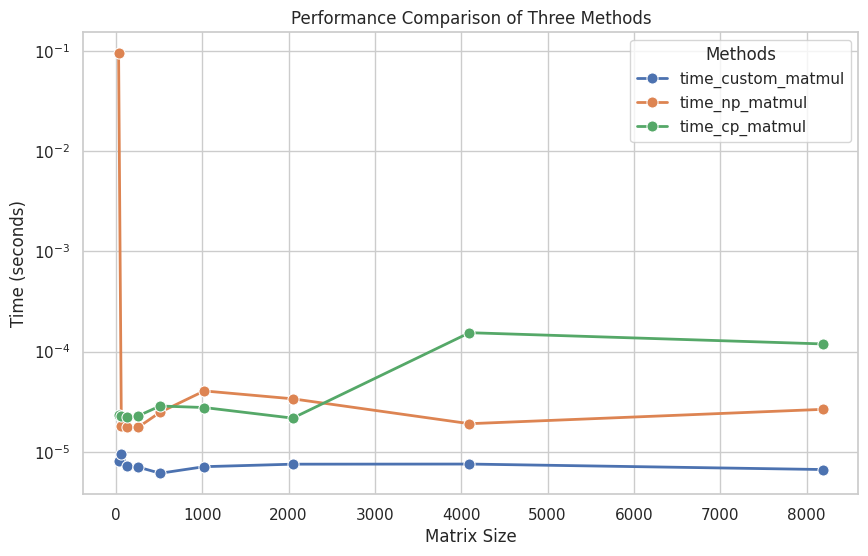

In [11]:

# Plotting the performance comparison for three methods
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot: Method vs Time for different matrix sizes
sns.lineplot(x='Size', y='Time', hue='Methods', data=df, marker='o', markersize=8, linestyle='-', linewidth=2)
plt.title('Performance Comparison of Three Methods')
plt.xlabel('Matrix Size')
plt.ylabel('Time (seconds)')
plt.yscale('log')
plt.legend(title='Methods')

plt.show()